<a href="https://colab.research.google.com/github/flediak/tensor_flow_image_classification/blob/main/cifar10_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!pip install tensorflow==2.8
!apt install --allow-change-held-packages libcudnn8=8.1.0.77-1+cuda11.2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 668.3 MB 17 kB/s 
     |████████████████████████████████| 1.4 MB 8.6 MB/s 
     |████████████████████████████████| 462 kB 71.0 MB/s 
     |████████████████████████████████| 5.8 MB 51.5 MB/s 
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.9.1
    Uninstalling tensorboard-2.9.1:
      Successfully uninstalled tensorboard-2.9.1
  Attempting uninstall: keras
    Found existing installation: keras 2.9.0
    Uninstalling keras-2.9.0:
      Successfully uninstalled keras-2.9.0
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.9.1
    Uninstalling tensorflow-2.9.1:
      Successfully uninstalled tensorflow-2.9.1
Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvid

In [4]:
from keras.datasets import mnist
from matplotlib import pyplot as plt
import numpy as np
import tensorflow as tf

In [5]:
print(tf.__version__)

2.8.0


In [6]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


# read data

In [7]:
from keras.datasets import cifar10

In [8]:
(X_train, Y_train), (X_test, Y_test) = cifar10.load_data()

170508288/170498071 [==============================] - 4s 0us/step


In [9]:
X_train.shape, X_test.shape

((50000, 32, 32, 3), (10000, 32, 32, 3))

In [10]:
X_train, X_test = X_train / 255., X_test / 255.

In [11]:
class_names = ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']

In [12]:
### for binary classification

'''
class1_name="cat"
class2_name="airplane"

# get IDs of class 1 and 2
class1_ID = np.arange(len(class_names))[np.array(class_names)==class1_name][0]
class2_ID = np.arange(len(class_names))[np.array(class_names)==class2_name][0]

# select the two classes from input data
select_train = (Y_train == class1_ID) | (Y_train == class2_ID)
select_test = (Y_test == class1_ID) | (Y_test == class2_ID)

X_train = X_train[select_train[:,0]]
Y_train = Y_train[select_train[:,0]]

X_test = X_test[select_test[:,0]]
Y_test = Y_test[select_test[:,0]]

# reset class values to 0 and 1 for class 1 and 2
Y_train = np.where(Y_train==class1_ID,0,1)
Y_test = np.where(Y_test==class1_ID,0,1)
'''

'\nclass1_name="cat"\nclass2_name="airplane"\n\n# get IDs of class 1 and 2\nclass1_ID = np.arange(len(class_names))[np.array(class_names)==class1_name][0]\nclass2_ID = np.arange(len(class_names))[np.array(class_names)==class2_name][0]\n\n# select the two classes from input data\nselect_train = (Y_train == class1_ID) | (Y_train == class2_ID)\nselect_test = (Y_test == class1_ID) | (Y_test == class2_ID)\n\nX_train = X_train[select_train[:,0]]\nY_train = Y_train[select_train[:,0]]\n\nX_test = X_test[select_test[:,0]]\nY_test = Y_test[select_test[:,0]]\n\n# reset class values to 0 and 1 for class 1 and 2\nY_train = np.where(Y_train==class1_ID,0,1)\nY_test = np.where(Y_test==class1_ID,0,1)\n'

# define models

In [16]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy') >= 0.95): # Experiment with changing this value
      print("\nReached 60% accuracy so cancelling training!")
      self.model.stop_training = True

In [17]:
callbacks = myCallback()

see
https://www.tensorflow.org/guide/distributed_training

In [15]:
mirrored_strategy = tf.distribute.MirroredStrategy()

In [22]:
with mirrored_strategy.scope():

  modelA = tf.keras.Sequential([
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(256, activation=tf.nn.relu),
      tf.keras.layers.Dense(10, activation=tf.nn.softmax)])
  
  modelB = tf.keras.Sequential([
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(64, activation=tf.nn.relu),
      tf.keras.layers.Dense(32, activation=tf.nn.relu),
      tf.keras.layers.Dense(10, activation=tf.nn.softmax)])

  modelC = tf.keras.Sequential([
      tf.keras.layers.Conv2D(128, (3,3), activation='relu', input_shape=(32, 32, 3)),
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(256, activation=tf.nn.relu),
      tf.keras.layers.Dense(10, activation=tf.nn.softmax)])

  modelD = tf.keras.Sequential([
      tf.keras.layers.Conv2D(128, (3,3), activation='relu', input_shape=(32, 32, 3)),
      tf.keras.layers.MaxPooling2D((2,2)),
      tf.keras.layers.Dropout(0.5),
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(256, activation=tf.nn.relu),
      tf.keras.layers.Dense(10, activation=tf.nn.softmax)])

  modelE = tf.keras.Sequential([
      tf.keras.layers.Conv2D(128, (3,3), activation='relu', input_shape=(32, 32, 3)),
      tf.keras.layers.MaxPooling2D((2,2)),
      tf.keras.layers.Dropout(0.5),
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(64, activation=tf.nn.relu),
      tf.keras.layers.Dense(32, activation=tf.nn.relu),
      tf.keras.layers.Dense(10, activation=tf.nn.softmax)])

" \n  modelD = tf.keras.Sequential([\n      tf.keras.layers.Conv2D(128, (3,3), activation='relu', input_shape=(32, 32, 3)),\n      tf.keras.layers.Flatten(),\n      tf.keras.layers.Dense(128, activation=tf.nn.relu),\n      tf.keras.layers.Dense(10, activation=tf.nn.softmax)])\n"

In [23]:
models = [modelA, modelB, modelC, modelD, modelE]

model_names = ['model A', ' model B', 'model C', 'model D', 'model E']

In [24]:
for model in models:
  model.compile( optimizer='adam', loss = 'sparse_categorical_crossentropy', metrics=['accuracy'])

# fit models

In [25]:
for i,model in enumerate(models):

  print('\nfit ' + model_names[i])
  model.fit(X_train, Y_train, validation_data=(X_test,Y_test), epochs=20, callbacks = myCallback())

fit model A
Epoch 1/20
1563/1563 [==============================] - 13s 6ms/step - loss: 1.8854 - accuracy: 0.3230 - val_loss: 1.7677 - val_accuracy: 0.3644
Epoch 2/20
1563/1563 [==============================] - 8s 5ms/step - loss: 1.7188 - accuracy: 0.3819 - val_loss: 1.6887 - val_accuracy: 0.4033
Epoch 3/20
1563/1563 [==============================] - 7s 4ms/step - loss: 1.6560 - accuracy: 0.4078 - val_loss: 1.6557 - val_accuracy: 0.4112
Epoch 4/20
1563/1563 [==============================] - 8s 5ms/step - loss: 1.6156 - accuracy: 0.4234 - val_loss: 1.6153 - val_accuracy: 0.4321
Epoch 5/20
1563/1563 [==============================] - 7s 5ms/step - loss: 1.5932 - accuracy: 0.4295 - val_loss: 1.5941 - val_accuracy: 0.4315
Epoch 6/20
1563/1563 [==============================] - 7s 4ms/step - loss: 1.5756 - accuracy: 0.4379 - val_loss: 1.5772 - val_accuracy: 0.4363
Epoch 7/20
1563/1563 [==============================] - 7s 5ms/step - loss: 1.5548 - accuracy: 0.4452 - val_loss: 1.5834 - 

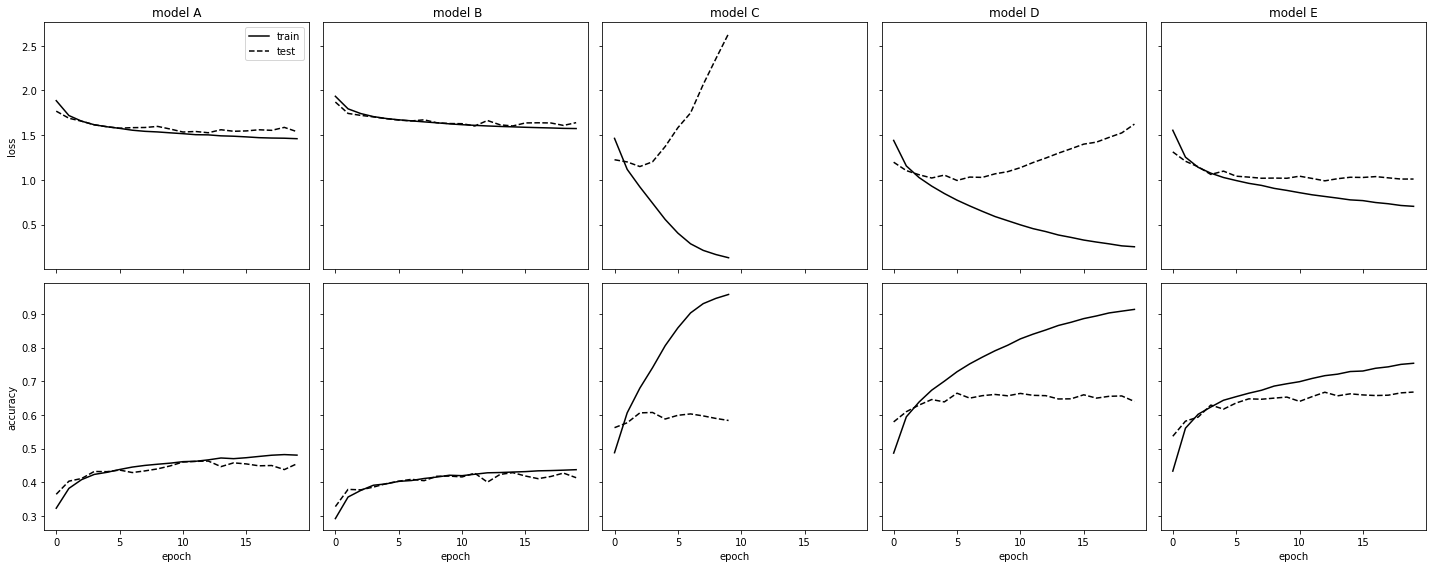

In [46]:
fig, ax = plt.subplots(2,len(models), figsize=(20,8), sharex=True, sharey='row')

ax[0,0].set_ylabel('loss')
ax[1,0].set_ylabel('accuracy')

for i in range(len(models)):
  ax[-1,i].set_xlabel('epoch')
  ax[0,i].set_title(model_names[i])

for i,model in enumerate(models):
  ax[0,i].plot(model.history.history['loss'], c='k', label = 'train')
  ax[0,i].plot(model.history.history['val_loss'], c='k', ls='--', label='test')
  ax[1,i].plot(model.history.history['accuracy'], c='k')
  ax[1,i].plot(model.history.history['val_accuracy'], c='k', ls='--')

ax[0,0].legend()

plt.tight_layout()
plt.show()

In [4]:
for model in models:
  print('\nevaluate ' + model_names[i])
  model.evaluate(X_test, Y_test)

NameError: ignored

# plot model predictions

In [50]:
classifications = modelE.predict(X_test)
Y_model = np.argmax(classifications, axis=1)

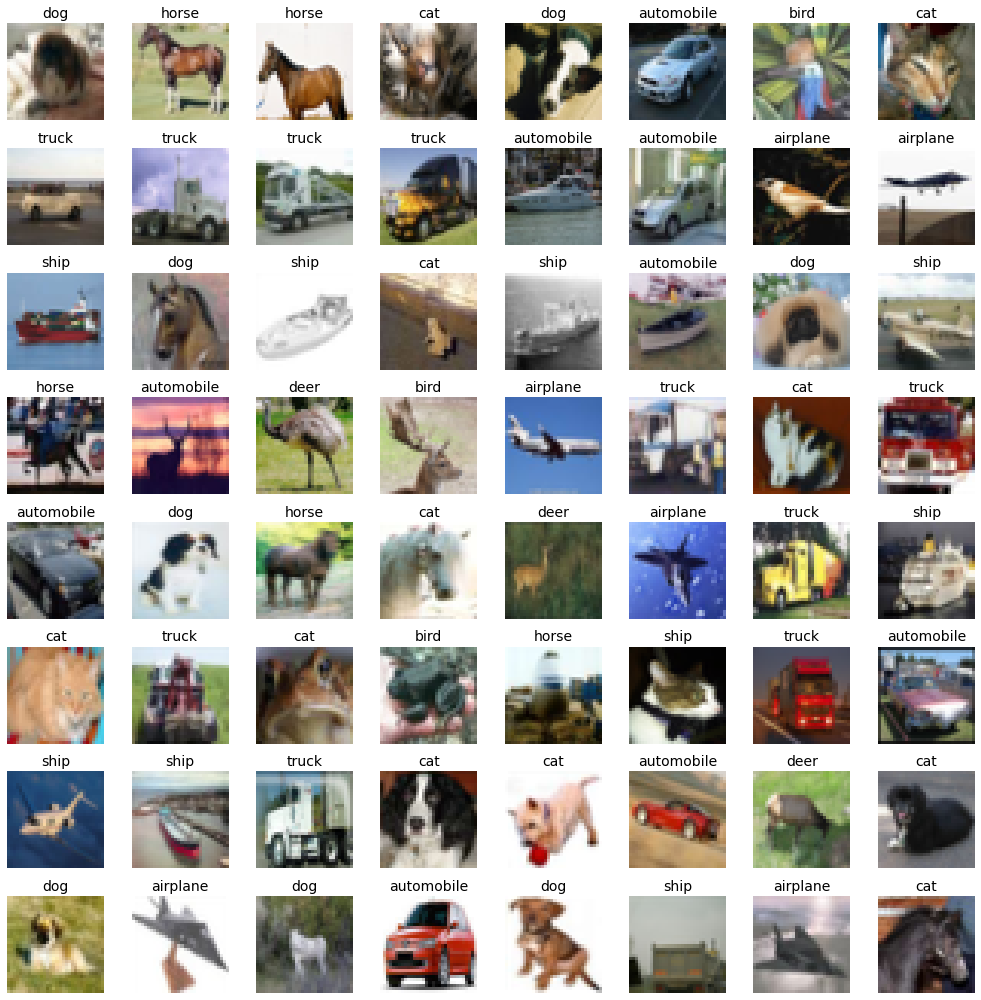

In [51]:
fig, ax = plt.subplots(8,8, figsize=(14,14))

imgID = 200
for ix in range(8):
    for iy in range(8):
        
        #if Y_model[imgID]==0:
        #    title = class1_name
        #else:
        #    title = class2_name
        title = class_names[Y_model[imgID]]

        ax[iy, ix].set_title(title, fontsize=14)
        
        ax[iy, ix].imshow(X_test[imgID], cmap=plt.get_cmap('gray'))
        
        ax[iy, ix].axis('off')
        
        imgID+=1
                

plt.tight_layout()            
plt.show()